In [1]:
import obspy
from obspy import read_inventory
from collections import defaultdict
from pathlib import Path
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json
import pickle
from joblib import Parallel,delayed
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
root_path = "/home/ahmadfervo/cape"
waveform_path = [
                "/home/ahmadfervo/cape/waveforms",
                # "/home/ahmadfervo/cape/20240601-10_earthquake_mseed",
                # "/home/ahmadfervo/cape/waveforms06_stacked"
                 ]
stations_path = f"{root_path}/b060_stations"
stationxml_path = f"{root_path}/stationxml"
phasenet_path = "/home/ahmadfervo/PhaseNet"
eqnet_path = "/home/ahmadfervo/EQNet"
b060_waveforms = "/mnt/qnap/Data/TAMU/b060_earthquake_mseed/"
iris_waveforms = f"{root_path}/iris_data/waveforms/"
EQnetResultDir=f'{root_path}/results_eqnet'

In [4]:
resp_files = glob.glob(f"{stationxml_path}/*.xml")
resp_files = [resp.split("/")[-1].replace(".xml","") for resp in resp_files]
resp_files[:3]

['CP.C0001..GP', 'CP.C0002..GP', 'CP.C0003..GP']

In [5]:
filenames = []
for wave_path in waveform_path:
    mseeds = glob.glob(f"{wave_path}/*/*.mseed")
    filenames += mseeds


# mseed_path=b060_waveforms+'/*/*.mseed'
# filenames = glob.glob(mseed_path)

# mseed_path=iris_waveforms+'/*/*.mseed'
# filenames += glob.glob(mseed_path)


# filenames=[file.split('/')[-2]+"/"+file.split('/')[-1] for file in filenames]
# _file_names=[]
# for net in network_list:

#     filtered_file_name = [file for file in filenames if not net in file]
#     _file_names+=filtered_file_name
    


filenames=np.unique(filenames)
print(len(filenames))
# filenames=np.insert(filenames, 0, 'fname')

640219


In [6]:
def is_valid_file(file):
    f = file.split("/")[-1].split("_")[-1].replace(".mseed", "")
    return f in resp_files and "6K." not in f

# Parallel processing to filter filenames
valid_filenames = Parallel(n_jobs=16)(delayed(is_valid_file)(file) for file in filenames)

# Keep only valid filenames
filenames = [file for file, valid in zip(filenames, valid_filenames) if valid]


# for file in filenames:
#     f = file.split("/")[-1].split("_")[-1].replace(".mseed","")

#     if not f in resp_files: filenames.remove(file)

print(len(filenames))
print(filenames[:3])



586802
['/home/ahmadfervo/cape/waveforms/eq00001/eq00001_UU.FORK.01.EH.mseed', '/home/ahmadfervo/cape/waveforms/eq00001/eq00001_UU.FORK.01.EN.mseed', '/home/ahmadfervo/cape/waveforms/eq00001/eq00001_UU.FORK.01.GH.mseed']


In [15]:
# stk_files = set([name for name in filenames if "CP.STK" in name])
# stk_files

In [7]:
Path(EQnetResultDir).mkdir(parents=True, exist_ok=True)
np.savetxt(EQnetResultDir+'/mseed.txt', filenames, fmt='%s')

In [8]:
# python predict.py --model phasenet_plus --data_list /s0/data/Oklahoma/pawnee_m4/results_phasenet/mseed.txt --response_path /s0/data/Oklahoma/pawnee_m4/station_response  --result_path /s0/data/Oklahoma/pawnee_m4/results_phasenet --batch_size=1 --format mseed
sampling_rate = 500
cmd = f"python {eqnet_path}/predict.py --model phasenet_plus --data_list {EQnetResultDir}/mseed.txt --response_path {stationxml_path} --result_path {EQnetResultDir} --sampling_rate {sampling_rate} --batch_size=1 --format mseed"
# "--sampling_rate", type=float, default=100, help="sampling rate; default 100.0 Hz"
print(cmd)

python /home/ahmadfervo/EQNet/predict.py --model phasenet_plus --data_list /home/ahmadfervo/cape/results_eqnet/mseed.txt --response_path /home/ahmadfervo/cape/stationxml --result_path /home/ahmadfervo/cape/results_eqnet --sampling_rate 500 --batch_size=1 --format mseed


In [9]:
# PhasenetResultDir=f'{root_path}/results_phasenet'
# Path(PhasenetResultDir).mkdir(parents=True, exist_ok=True)
# mseed_path=waveform_path+'/*/*.mseed'
# filenames = glob.glob(mseed_path)

# filenames=[file.split('/')[-2]+"/"+file.split('/')[-1] for file in filenames]
# filenames=np.unique(filenames)
# # print('number of stations',len(filenames))
# filenames=np.insert(filenames, 0, 'fname')

# np.savetxt(PhasenetResultDir+'/mseed.csv', filenames, fmt='%s')
# filenames[:3]

array(['fname', 'eq00025/eq00025_CP.STK00..GP.mseed',
       'eq00025/eq00025_CP.STK01..GP.mseed'], dtype='<U34')

In [12]:
# cmd = f"nohup python {phasenet_path}/phasenet/predict.py --model={phasenet_path}/model/190703-214543 --data_list={PhasenetResultDir}/mseed.csv --data_dir={waveform_path}/ --result_dir={PhasenetResultDir} --stations={stations_path}/stations.json  --format=mseed_array --amplitude &"

# print(cmd)

nohup python /home/ahmadfervo/PhaseNet/phasenet/predict.py --model=/home/ahmadfervo/PhaseNet/model/190703-214543 --data_list=/home/ahmadfervo/cape/results_phasenet/mseed.csv --data_dir=/mnt/qnap/Data/TAMU/b060_earthquake_mseed/ --result_dir=/home/ahmadfervo/cape/results_phasenet --stations=/home/ahmadfervo/cape/b060_stations/stations.json  --format=mseed_array --amplitude &


In [5]:
# picks = pd.read_csv(f"{EQnetResultDir}/picks_phasenet_plus.csv")
# picks[:3]

In [3]:
pick_files = glob.glob(f"{EQnetResultDir}/picks_phasenet_plus/*")
# pick_files = glob.glob("/home/ahmadfervo/cape/results_eqnet.184/picks_phasenet_plus/*.csv")
pick_files = list(filter(lambda file: os.stat(file).st_size > 0, pick_files))
print(len(pick_files))
pick_files[:3]

742801


['/home/ahmadfervo/cape/results_eqnet06/picks_phasenet_plus/eq06737_CP.C0001..GP.csv',
 '/home/ahmadfervo/cape/results_eqnet06/picks_phasenet_plus/eq06737_CP.C0002..GP.csv',
 '/home/ahmadfervo/cape/results_eqnet06/picks_phasenet_plus/eq06737_CP.C0003..GP.csv']

In [4]:
def read_csv(_csv):
# station_id,phase_index,phase_time,phase_score,phase_type,dt_s,phase_polarity,phase_amplitude
    df = pd.read_csv(_csv)
    event_index = _csv.split("/")[-1].split("_")[0]
    df["event_index"] = event_index
        
    return df


# def read_csv(_csv):
# # station_id,phase_index,phase_time,phase_score,phase_type,dt_s,phase_polarity,phase_amplitude
#     file_size = os.path.getsize(_csv)

#     if file_size > 0:
#         df = pd.read_csv(_csv)
#         event_index = _csv.split("/")[-1].split("_")[0]
#         df["event_index"] = event_index
#     else:
#         df = pd.DataFrame(columns=["station_id","event_index","phase_index","phase_time","phase_score",
#                                    "phase_type","dt_s","phase_polarity","phase_amplitude"])
        
#     return df

In [10]:
# def read_csv(_csv):
# # station_id,phase_index,phase_time,phase_score,phase_type,dt_s,phase_polarity,phase_amplitude
#     file_size = os.path.getsize(_csv)

#     if file_size > 0:
#         df = pl.read_csv(_csv)
#         event_index = _csv.split("/")[-1].split("_")[0]
#         df["event_index"] = event_index
#     else:
#         df = pl.DataFrame.with_columns({"station_id":[],
#                            "event_index":[],
#                            "phase_index":[],
#                            "phase_time":[],
#                            "phase_score":[],
#                             "phase_type":[],
#                             "dt_s":[],
#                             "phase_polarity":[],
#                             "phase_amplitude":[]})
        
#     return df

In [5]:


# Parallel(n_jobs=16)(delayed(add_event_data)(row, _picks, _inv, _stations, _evid_dict, _stid_dict) for row in rows)
picks = pd.concat(
    Parallel(n_jobs=8)(delayed(read_csv)(pick_file) for pick_file in pick_files),
    ignore_index=True
)
picks[:3]

,station_id,phase_index,phase_time,phase_score,phase_type,dt_s,phase_polarity,phase_amplitude,event_index
0,CP.C0001..GP,484,2024-06-01T14:16:51.611,0.934,P,0.004,-0.879,0.000420,eq06737
1,CP.C0001..GP,731,2024-06-01T14:16:52.599,0.338,S,0.004,0.100,0.000128,eq06737
2,CP.C0002..GP,484,2024-06-01T14:16:51.611,0.945,P,0.004,-0.895,0.000469,eq06737


In [6]:
picks.to_csv(f"{EQnetResultDir}/picks.csv",index=False,float_format="%.8f")
len(picks)

1614707

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
unipicks = picks.drop_duplicates(subset=["event_index","station_id","phase_type"])
len(unipicks)

1215247

In [13]:
events_id = unipicks["event_index"].unique()
# sn = Parallel(n_jobs=8,verbose=10)(delayed(len)(unipicks[unipicks["event_index"]==evid]) for evid in events_id)
# sn = [len(unipicks[unipicks["event_index"]==evid]) for evid in events_id]

# for evid in tqdm(events_id):
#     sn.append(len(unipicks[unipicks["event_index"]==evid]))


In [13]:
df = pd.DataFrame({"event_index":events_id, "number_of_picks":sn})

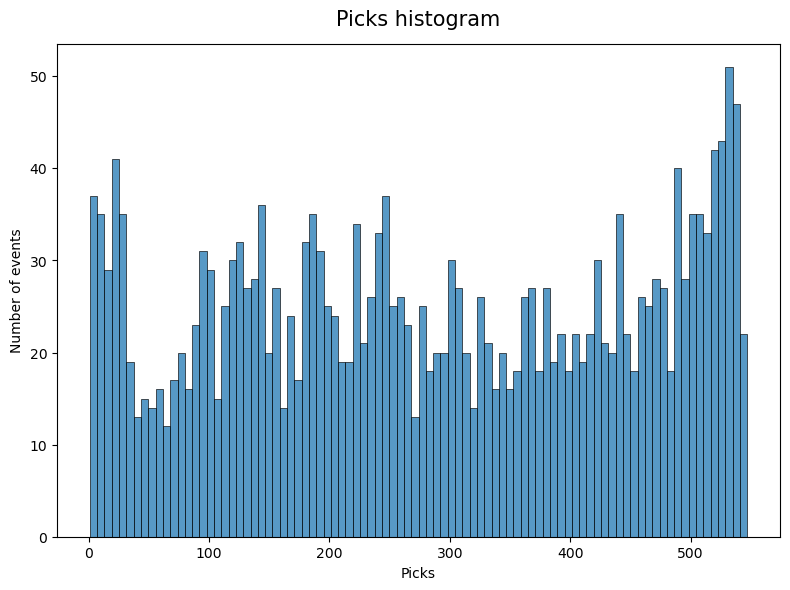

In [18]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
sns.histplot(data=df,x='number_of_picks',bins=90)
ax.set_xlabel('Picks')
ax.set_ylabel('Number of events')
ax.set_title(r'Picks histogram', y=1.02, fontsize=15)
# plt.legend()
fig.tight_layout()

In [9]:
ppick=unipicks[unipicks["phase_type"]=="P"]
spick=unipicks[unipicks["phase_type"]=="S"]
print(len(ppick))
print(len(spick))

124109
110954


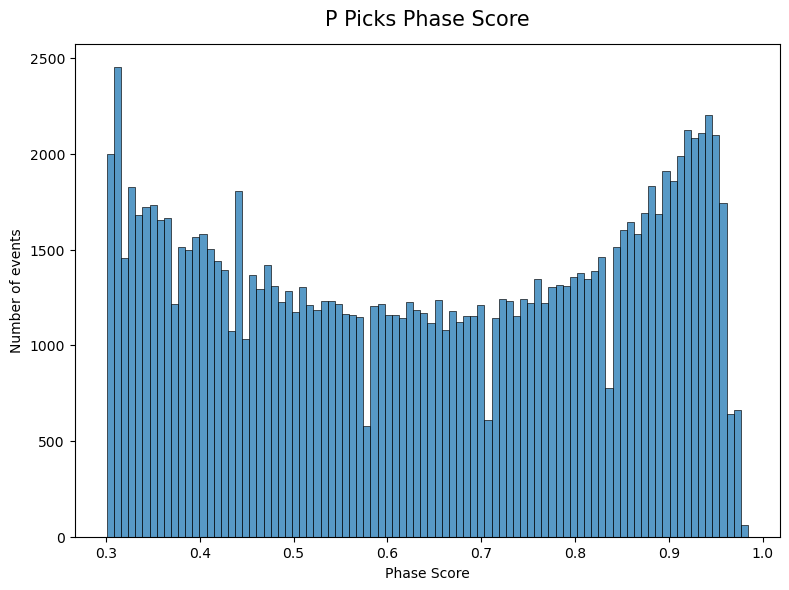

In [10]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
sns.histplot(data=ppick,x='phase_score',bins=90)
ax.set_xlabel('Phase Score')
ax.set_ylabel('Number of events')
ax.set_title(r'P Picks Phase Score', y=1.02, fontsize=15)
fig.tight_layout()

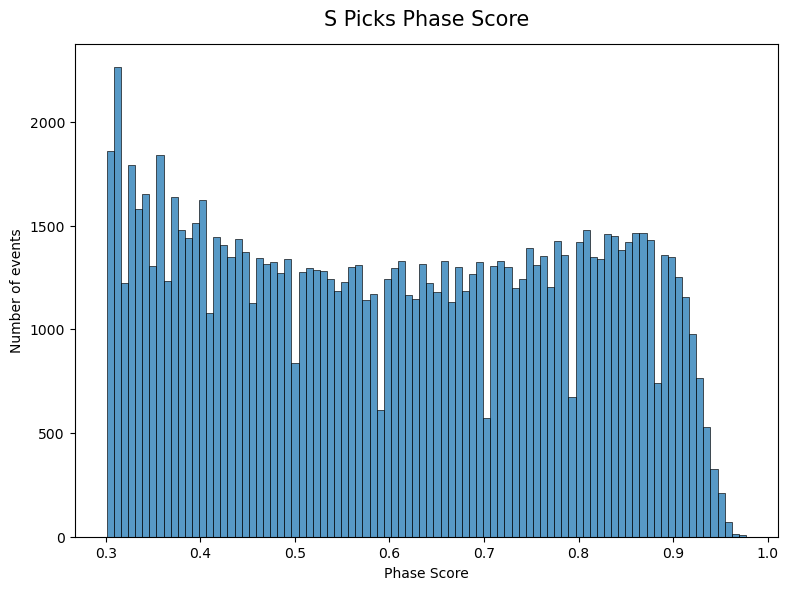

In [11]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
sns.histplot(data=spick,x='phase_score',bins=90)
ax.set_xlabel('Phase Score')
ax.set_ylabel('Number of events')
ax.set_title(r'S Picks Phase Score', y=1.02, fontsize=15)
fig.tight_layout()

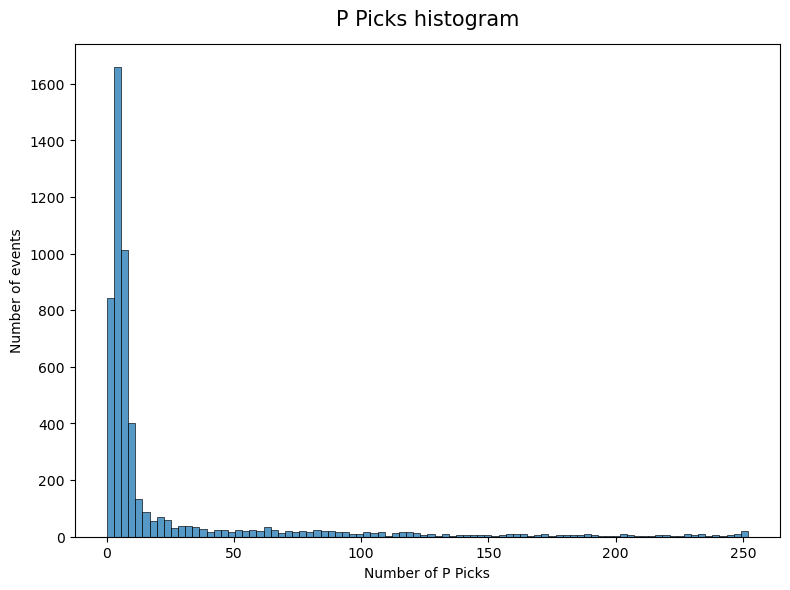

In [14]:
psn = [len(ppick[ppick["event_index"]==evid]) for evid in events_id]
pdf = pd.DataFrame({"event_index":events_id, "number_of_picks":psn})

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
sns.histplot(data=pdf,x='number_of_picks',bins=90)
ax.set_xlabel('Number of P Picks')
ax.set_ylabel('Number of events')
ax.set_title(r'P Picks histogram', y=1.02, fontsize=15)
# plt.legend()
fig.tight_layout()

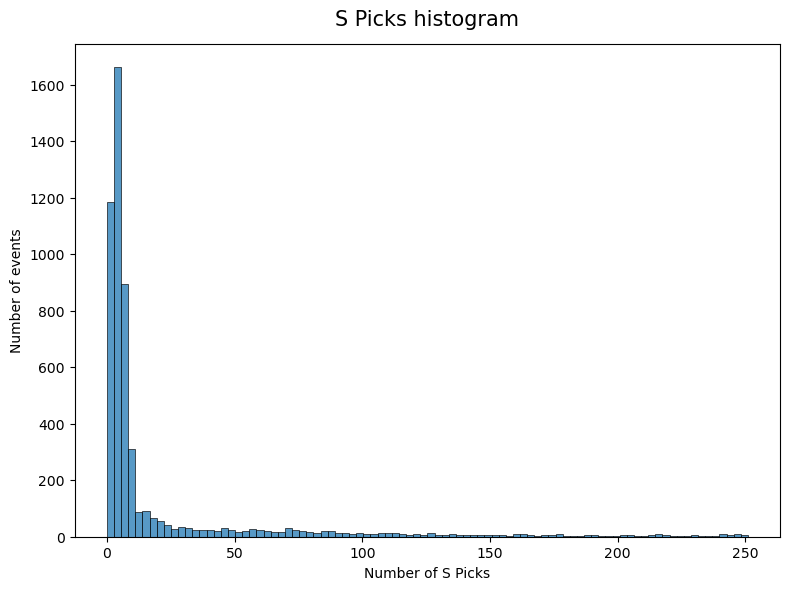

In [15]:
ssn = [len(spick[spick["event_index"]==evid]) for evid in events_id]
sdf = pd.DataFrame({"event_index":events_id, "number_of_picks":ssn})

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
sns.histplot(data=sdf,x='number_of_picks',bins=90)
ax.set_xlabel('Number of S Picks')
ax.set_ylabel('Number of events')
ax.set_title(r'S Picks histogram', y=1.02, fontsize=15)
# plt.legend()
fig.tight_layout()

In [16]:
picks["station_id"].unique()

array(['CP.C0001..GP', 'CP.C0002..GP', 'CP.C0003..GP', 'CP.C0004..GP',
       'CP.C0005..GP', 'CP.C0007..GP', 'CP.C0008..GP', 'CP.C0009..GP',
       'CP.C0011..GP', 'CP.C0012..GP', 'CP.C0013..GP', 'CP.C0014..GP',
       'CP.C0016..GP', 'CP.C0019..GP', 'CP.C0020..GP', 'CP.C0021..GP',
       'CP.C0022..GP', 'CP.C0023..GP', 'CP.C0025..GP', 'CP.C0027..GP',
       'CP.C0029..GP', 'CP.C0030..GP', 'CP.C0031..GP', 'CP.C0032..GP',
       'CP.C0037..GP', 'CP.C0038..GP', 'CP.C0039..GP', 'CP.C0041..GP',
       'CP.C0045..GP', 'CP.C0047..GP', 'CP.C0048..GP', 'CP.C0049..GP',
       'CP.C0050..GP', 'CP.C0054..GP', 'CP.C0055..GP', 'CP.C0056..GP',
       'CP.C0057..GP', 'CP.C0058..GP', 'CP.C0059..GP', 'CP.C0061..GP',
       'CP.C0062..GP', 'CP.C0063..GP', 'CP.C0064..GP', 'CP.C0065..GP',
       'CP.C0066..GP', 'CP.C0067..GP', 'CP.C0068..GP', 'CP.C0069..GP',
       'CP.C0070..GP', 'CP.C0071..GP', 'CP.C0072..GP', 'CP.C0073..GP',
       'CP.C0074..GP', 'CP.C0075..GP', 'CP.C0076..GP', 'CP.C0077..GP',
      

In [24]:
# picks = pd.concat(map(read_csv,files),ignore_index=True)
# # picks = pd.read_csv(files)
# picks[:3]

,station_id,phase_index,phase_time,phase_score,phase_type,dt_s,phase_polarity,phase_amplitude,event_index
0,CP.STK04..GP,140,2024-02-10T02:39:33.366,0.305,P,0.01,0.402,1.064000e-07,eq00011
1,CP.C0002..GP,150,2024-02-11T16:10:57.180,0.424,P,0.01,0.781,1.836000e-03,eq00017
2,CP.C0002..GP,288,2024-02-11T16:10:58.560,0.416,S,0.01,-0.036,1.836000e-03,eq00017


In [7]:
picks.to_csv(f"{EQnetResultDir}/picks.csv",index=False,float_format="%.8f")

In [36]:
df1 = pl.DataFrame({"station_id":[],
                           "event_index":[],
                           "phase_index":[],
                           "phase_time":[],
                           "phase_score":[],
                            "phase_type":[],
                            "dt_s":[],
                            "phase_polarity":[],
                            "phase_amplitude":[]})

df1

station_id,event_index,phase_index,phase_time,phase_score,phase_type,dt_s,phase_polarity,phase_amplitude
null,null,null,null,null,null,null,null,null


In [33]:
df = pl.read_csv(pick_files[500])
df = df.with_columns(
    event_index = pl.lit('some_text')
)
df

station_id,phase_index,phase_time,phase_score,phase_type,dt_s,phase_polarity,phase_amplitude,event_index
str,i64,str,f64,str,f64,f64,f64,str
"""CP.C1905..GP""",112,"""2024-02-11T16:10:56.800""",0.512,"""P""",0.01,-0.762,40.68,"""some_text"""
"""CP.C1905..GP""",195,"""2024-02-11T16:10:57.630""",0.426,"""S""",0.01,-0.039,40.68,"""some_text"""


In [34]:
pl.concat([df1,df],rechunk=True)

SchemaError: type String is incompatible with expected type Null